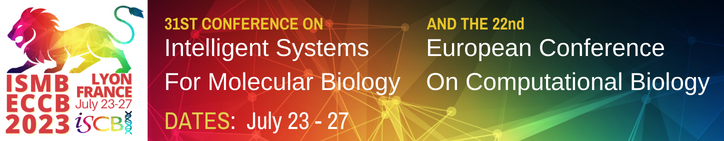

#**VT2: Protein Sequence Analysis using Transformer-based Large Language Model**

## **Part-2B :  Case study 1: Protein Function Prediction.**

31st Conference on Intelligent Systems for Molecular Biology (ISMB) /
22nd European Conference on Computational Biology (ECCB)

**Venue:** Hybrid (Virtual/Lyon,France)

**Date of the session:** July 17-18, 2023

**Instructor :** Sayane Shome, PhD

**Affiliation :** Stanford University School of Medicine, California,USA


Please cite this tutorial as:

**Bishnu Sarker, Sayane Shome, Farzana Rahman, Nima Aghaeepour (2023, July). Tutorial VT2: Protein Sequence Analysis using Transformer-based Large Language Model. In 31st Conference on Intelligent Systems for Molecular Biology and 22nd European Conference on Computational Biology (ISMB/ECCB 2023), Lyon, France.**

##### **Protein Function Prediction**
Protein function prediction is prominent problem in computational biology wherein given a protein sequence, the function of the protein is predicted in terms of [Gene Ontology](http://geneontology.org/) or [Brenda](https://www.brenda-enzymes.org/). Manual function annotation involves a tedious process of analyzing research articles to find the functional association of proteins. However, to keep up pace with the growing number of protein sequences deposited in public databases, [automatic functional annotation](https://www.uniprot.org/help/automatic_annotation) is now gaining attention.For instance, UniProtKB historically has been using multiple annotationa piplelines such as [UniRule](https://www.uniprot.org/unirule?query=*), [SAAS](https://www.uniprot.org/help/saas), [ARBA](https://www.uniprot.org/help/arba) and most recently, [ProtNLM](https://www.uniprot.org/help/ProtNLM). These methods are developed based on various computational techniques ranging from rule based annotation to deep learning based models.  

In this section, as our first case study, we will build a model for automatic protein function prediction. We will leverage the power of Transformer-based Large Language Model for determining the protein functions. Due to the time  limitations and resource constraints, we will be using pre-generated embeddings downloaded  from  https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/embeddings/uniprot_sprot/per-protein.h5

Ideally, one should be using a pre-trained model to generate the embeddings against the amino acid sequences. However, as we have mentioned earlier, due to resource constraints, it is infeasible to generate the embeddings inline for a bulk size of input sequences.

Particularly for this case-study, we have collected the publicly available embeddings from the UniProtKB following the steps:
1. We have mapped the structure ID given in our dataset to UniProt Entry ID by using the following services from UniProtKB: https://www.uniprot.org/id-mapping
2. We have downloaded UniProtKB/SwissProt embeddings from https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/embeddings/uniprot_sprot/per-protein.h5 .This embeddings are generated by using ProtT5 model that we have seen in the Part-2B hands-on session. In this file, a UniProtKB protein ID is linked to an embedding generated by running [ProtT5](https://arxiv.org/pdf/2007.06225.pdf) encoder model on the corresponding amino acid sequence.
3.  With some further processing, we have prepared a Pandas DataFrame comprising of associated embeddings, ids and labels.
4. And finally, we saved the DataFrame as a pickle file for easier and quick data loading here.

In summary, the objectives in the case study are:
1. Data loading, pre-processing and formatting to generate embeddings.
2. Building a logistic regression model to classify sequenecs into their labels.

#### Import Packages

In [1]:
# Loading general data science packages
import pandas as pd
import numpy as np

# For visualization support,we will load matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
%matplotlib inline

# package for random choice generation
import random
from random import sample

# for machine learning tasks,we are loading pytorch and scikit-learn
import sklearn as sk
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import h5py

#### Load Data

In this step, we will load both the data file: 1) sequence file, 2) embeddings.

In [ ]:
## Loading data
from google.colab import drive
drive.mount('/content/drive')

## Setting working directory
%cd /content/drive/MyDrive/ISMB_ECCB_2023



Loading the sequence file.

In [ ]:
data_path="data/Seq_class.csv"
df=pd.read_csv(data_path)
data_seqs=list(df.sequence)
data_labels=list(df.classification)
labels=list(set(data_labels))
n_labels=len(labels)
print(f'{len(data_seqs)}, {len(data_labels)}')

37951, 37951


In [ ]:
df.head(5)

,structureId,sequence,classification
0,177L,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,HYDROLASE
1,178L,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,HYDROLASE
2,1A0I,VNIKTNPFKAVSFVESAIKKALDNAGYLIAEIKYDGVRGNICVDNT...,LIGASE
3,1A16,SEISRQEFQRRRQALVEQMQPGSAALIFAAPEVTRSADSEYPYRQN...,HYDROLASE/HYDROLASE INHIBITOR
4,1A17,RDEPPADGALKRAEELKTQANDYFKAKDYENAIKFYSQAIELNPSN...,HYDROLASE


Here, a significant amount of off-the-screen pre-processing has been performed to ensure the data is in the correct format. One of the primary challenges was obtaining the UniProt IDs corresponding to the structure IDs provided in the original data. Following additional preprocessing and data cleaning steps, the resulting file has been saved for convenient demonstration purposes.

The pre-processing steps involved various data transformations, alignment of IDs, and cleaning procedures to ensure the data is properly formatted and ready for analysis. By saving the processed file, we can easily showcase the subsequent steps without the need for extensive pre-processing during the demonstration.

#### Loading Embeddings

In [ ]:
embedding_df=pd.read_pickle('data/case_study_1.pkl')

In [ ]:
embedding_df.head(5)

,pdbId,uniprotId,sequence,embedding,classification
0,177L,P00720,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,"[0.0357, -0.02739, 0.06226, 0.0241, 0.048, -0....",HYDROLASE
1,178L,P00720,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,"[0.0357, -0.02739, 0.06226, 0.0241, 0.048, -0....",HYDROLASE
2,1A0I,P00969,VNIKTNPFKAVSFVESAIKKALDNAGYLIAEIKYDGVRGNICVDNT...,"[0.05447, -0.0781, -0.01279, 0.002829, -0.0485...",LIGASE
3,1A16,P15034,SEISRQEFQRRRQALVEQMQPGSAALIFAAPEVTRSADSEYPYRQN...,"[0.08923, 0.10504, 0.01293, 0.02536, 0.002459,...",HYDROLASE/HYDROLASE INHIBITOR
4,1A17,P53041,RDEPPADGALKRAEELKTQANDYFKAKDYENAIKFYSQAIELNPSN...,"[0.0579, 0.1092, 0.0112, 0.02176, 0.0195, 0.02...",HYDROLASE


In [ ]:
len(embedding_df)


29824

The processed dataset contains 29824 records reduced from 37951 records in the original dataset. This reduction happened due to two reasons: 1) No mappings were found for few structure IDs. and 2) No embeddings were found for few IDs. IDs are deprecated often times in UniProtKB. One extra layer of pre-processing may get few more embeddings added in the dataset.

#### Building Regression Model for Automatic Protein Function Annotation

Now the data is ready to be feed into any machine learning model for the function prediction task. We will build a simple logistic regression model using the retrieved embeddings.

Although it is typical to use gene ontology(GO) terms or Enzyme Commission Numbers (EC) to represent functions, for the simplicity will use textual labels as functions.

##### Exploratory Data Analysis

Number of unique labels in the dataset

In [ ]:
X=list(embedding_df.embedding)
Y=list(embedding_df.classification)
labels=list(set(Y))
n_labels=len(labels)
n_labels

25

Distribution of instances per label

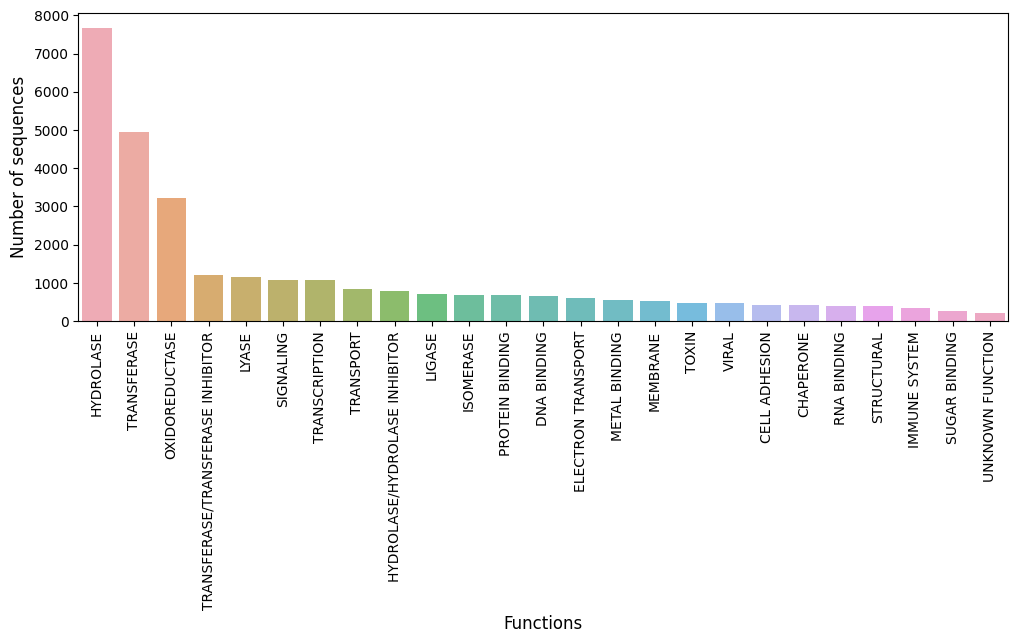

In [ ]:
cnt_pro = embedding_df['classification'].value_counts()
plt.figure(figsize=(12,4))
#print(cnt_pro)
sns.barplot(x=cnt_pro.index, y=cnt_pro.values, alpha=0.8)
plt.ylabel('Number of sequences', fontsize=12)
plt.xlabel('Functions', fontsize=12)
plt.xticks(rotation=90)
plt.show();

The data set is an ideal example of class imbalance machine learning problem as it is evident from the above bar chart.  

#### Model Building

Now, let's move to model building.

Import necessary functions from *sklearn* machine learning package.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Split the dataset into training and testing set. The instances are stratified according to labels.

In [ ]:
x_train, x_test, y_train, y_test=train_test_split(X,Y, test_size=0.2, random_state=120, stratify=Y)

Initializing the model setting mazimum number of interations to 300 and L2 regularization.

In [ ]:
model=LogisticRegression(penalty='l2', max_iter=300)

Fitting the data into the model.

In [ ]:
model.fit(x_train, y_train)
#training the model

LogisticRegression(max_iter=300)

#### Performance Evaluation

Generating the classification report

In [ ]:
cr=classification_report(model.predict(x_test), y_test)

In [ ]:
print(cr)
#printing the performance metrics of the model training

                                   precision    recall  f1-score   support

                    CELL ADHESION       0.64      0.61      0.63        92
                        CHAPERONE       0.80      0.79      0.80        86
                      DNA BINDING       0.53      0.66      0.59       104
               ELECTRON TRANSPORT       0.89      0.87      0.88       124
                        HYDROLASE       0.92      0.81      0.86      1761
    HYDROLASE/HYDROLASE INHIBITOR       0.04      0.86      0.07         7
                    IMMUNE SYSTEM       0.63      0.66      0.64        67
                        ISOMERASE       0.72      0.91      0.81       110
                           LIGASE       0.59      0.86      0.70        95
                            LYASE       0.77      0.88      0.82       205
                         MEMBRANE       0.50      0.46      0.48       114
                    METAL BINDING       0.49      0.76      0.60        72
                   OXIDO

Classification report generates a comprehensive report of model performance by showing label wise precision, recall, f1-score and accuracy. A higher value is considered to be the indicator of superior performance.  A comprehensive description of the evaluation metrices can be found [here](https://txt.cohere.com/classification-eval-metrics/).   

##### Confusion Matrix
Similar to Part-1B, we have constructed a confusion matrix in this section. We have utilized a convenient function provided by Scikit-learn to create the confusion matrix.

The confusion matrix serves as a valuable tool for visualizing the performance of our model. It provides insights into how the predicted labels compare to the true labels. By analyzing the confusion matrix, we can identify patterns of correct classifications and misclassifications, gaining a comprehensive understanding of the model's performance.

Scikit-learn's functionality allows us to easily generate and visualize the confusion matrix, aiding in the evaluation and interpretation of our model's predictions.

In [ ]:
m=confusion_matrix(y_test, model.predict(x_test))
#we will be plotting the confusion matrix in next set of code which to do what ?

In [ ]:
def plot_confusion(confusion_mat, unique_labels):

  fig=plt.figure()
  ax=fig.add_subplot(111)
  cax=ax.matshow(confusion_mat)
  fig.colorbar(cax)

  ax.set_xticklabels(['']+unique_labels, rotation=90)
  ax.set_yticklabels(['']+unique_labels)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

<ipython-input-17-f1a09435aa62>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+unique_labels, rotation=90)
<ipython-input-17-f1a09435aa62>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+unique_labels)


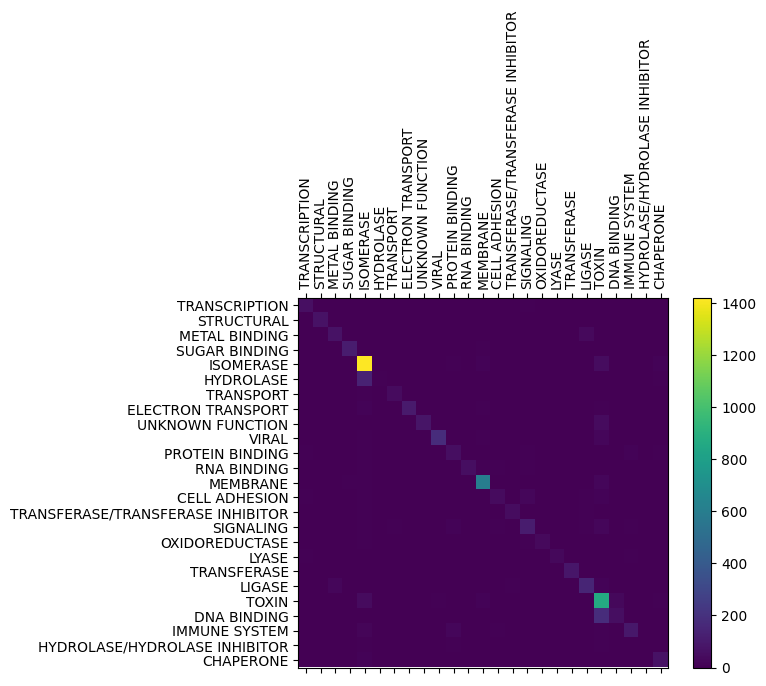

In [ ]:
plot_confusion(m, unique_labels=labels)

#### **Conclusion**

This hands-on session serves as a template for constructing a machine learning model designed to automate protein function annotation. Directly applying raw protein sequences to a machine learning model is not feasible due to the complexity and size of the data. To overcome this challenge, we have employed transformer-based large language models.

These powerful models allow us to extract low-rank numerical representations, also known as embeddings, from amino acid sequences. In this case, we have utilized a pre-trained model to generate embeddings for each protein in the UniProtKB protein repository. Each protein is represented by a 1024-dimensional embedding.

To prepare the data for training a machine learning model, we have constructed a data matrix utilizing these pre-generated embeddings. This data matrix can be used with scikit-learn's machine learning models for further analysis and predictions.

In this demonstration, we have trained a logistic regression model to showcase the performance of automatic protein function prediction. Logistic regression is a popular choice for classification tasks and can effectively leverage the embeddings to predict protein functions.

By following this template, you can build your own machine learning models for protein function annotation, incorporating pre-trained embeddings and leveraging the power of transformer-based models.

We would like to acknowledge following sources:
1. https://github.com/agemagician/ProtTrans
2. https://towardsdatascience.com/transformers-explained-visually-part-1-overview-of-functionality-95a6dd460452
3. https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/
4. https://github.com/DeepChainBio/bio-transformers/tree/main
